In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

In [2]:
from extract_data import extract_data
from finbeat_calc import finbeat_calc
from plot_accel import plot_accel
from plot_track import plot_track

# Take position data from hardcoded folder, calc. velocities, accels
tracklist = extract_data()

# Calculate finbeat peaks and troughs

finbeats = finbeat_calc(tracklist.keys(), tracklist)

# Extract finbeat periods, amplitudes, and subsequent accel

# Plot things if desired
# plot_track(['sometrial'], tracklist)
# plot_accel(['sometrial'], tracklist)

"""If you want to plot the peaks and troughs on the position data,
uncomment section in finbeat_calc"""

Bass1S01
Bass1S02
Bass1S03
Bass1S04
Bass1S05
Bass1S06
Bass1S07


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

Bass1S08
Bass1S09
Bass1S10
Bass1S11
Bass1S12
Bass1S13
Bass1S14


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

Bass1S15
Bass1S16
Bass1S17
Bass1S18
Bass1S19
Bass1S20
Bass1S21


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

Bass1S22
Bass1S23
BTrout1S01
BTrout1S02
BTrout1S03
BTrout1S04
BTrout1S05
BTrout1S06


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

BTrout1S07a
BTrout1S08
BTrout1S09
BTrout1S10
BTrout1S11
BTrout2S01
BTrout2S02


C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
C:\Anaconda3\

BTrout2S03
BTrout2S04
BTrout2S05
BTrout2S07
BTrout2S14a


'If you want to plot the peaks and troughs on the position data,\nuncomment section in finbeat_calc'

In [3]:
tracklist

{'BTrout1S01': {'FPS': 500,
  'behavior': 'S',
  'data':        pt1_cam1_X       pt1z      pt1x       pt1y  pt2_cam1_X       pt2z  \
  time                                                                       
  0.000  278.874267  10.650374  5.826050  21.986715  641.463247  10.471626   
  0.002  278.970000  10.641672  5.815733  21.982153  641.020000  10.479154   
  0.004  278.920000  10.640304  5.813805  21.980225  641.030000  10.479701   
  0.006  278.860000  10.638662  5.811876  21.978618  641.020000  10.478606   
  0.008  278.830000  10.636747  5.809305  21.977011  641.060000  10.478059   
  0.010  278.760000  10.635379  5.804484  21.978939  640.990000  10.479427   
  0.012  278.740000  10.633464  5.794842  21.982474  640.990000  10.478333   
  0.014  278.660000  10.630728  5.791307  21.981510  640.980000  10.479154   
  0.016  278.830000  10.616227  5.788735  21.979903  640.960000  10.479427   
  0.018  278.780000  10.614586  5.787128  21.978296  640.990000  10.479154   
  0.020  

In [11]:
tracklist['Bass1S01']['data']

,pt1_cam1_X,pt1z,pt1x,pt1y,pt2_cam1_X,pt2z,pt2x,pt2y,pt1x_smth,pt1y_smth,...,pt1x_a,pt1y_a,pt1z_a,pt2x_a,pt2y_a,pt2z_a,pt1_net_v,pt2_net_v,pt1_net_a,pt2_net_a
time,,,,,,,,,,,,,,,,,,,,,
0.000,217.347601,12.647995,4.291806,20.440010,752.340191,12.710832,19.846640,22.436853,4.304476,20.425388,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.001,217.000000,12.636930,4.297380,20.428590,752.000000,12.717152,19.851651,22.449962,4.303758,20.425944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.002,216.980000,12.636930,4.297380,20.429231,752.050000,12.717957,19.851651,22.452207,4.303036,20.426479,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.003,216.970000,12.636930,4.296739,20.429552,752.020000,12.717688,19.880867,22.446993,4.302312,20.426992,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.004,216.990000,12.636930,4.297059,20.429231,752.040000,12.717420,19.883721,22.450924,4.301584,20.427485,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.005,216.990000,12.637198,4.296739,20.429231,752.010000,12.717152,19.887712,22.416573,4.300853,20.427956,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.006,216.970000,12.636930,4.296097,20.429552,752.020000,12.717957,19.883721,22.417892,4.300120,20.428406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.007,216.980000,12.636662,4.296418,20.429552,752.000000,12.717957,19.883721,22.418854,4.299383,20.428835,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.008,216.960000,12.636930,4.296097,20.429231,751.980000,12.717688,19.883721,22.423023,4.298644,20.429242,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
from plot_track import *
from plot_accel import *

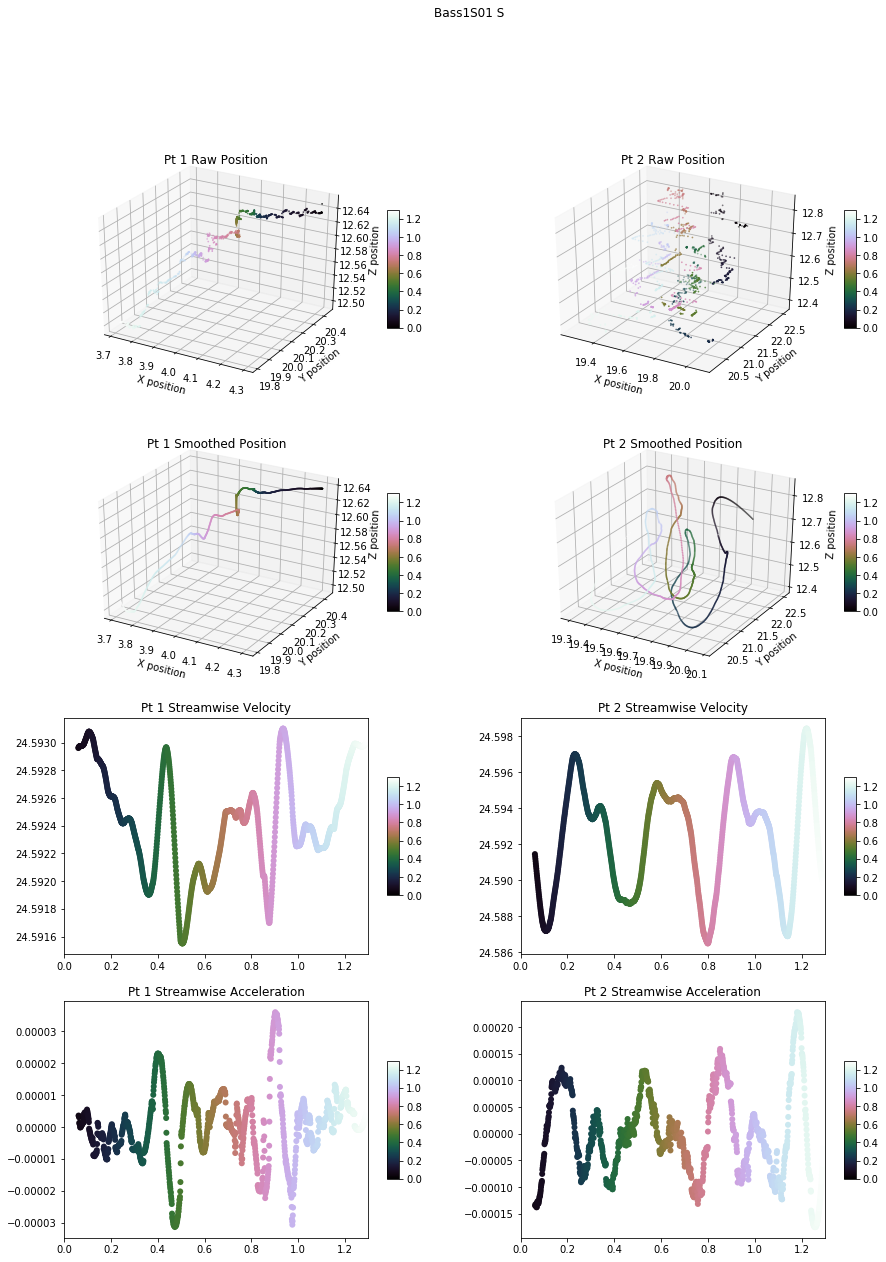

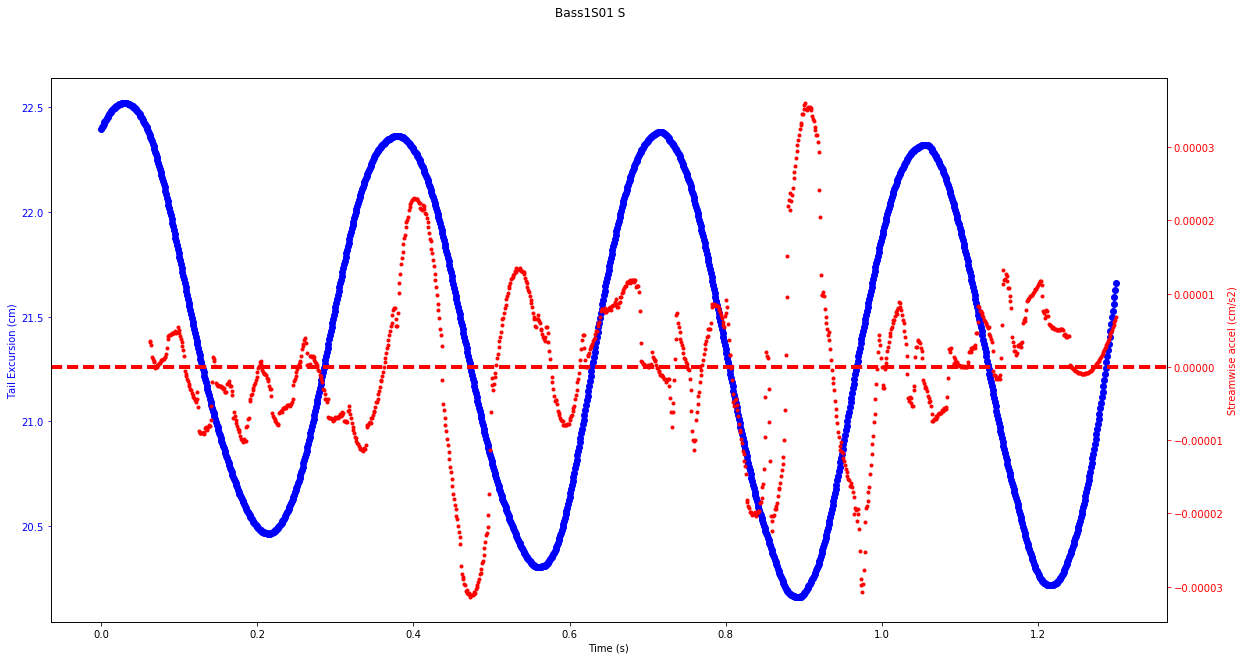

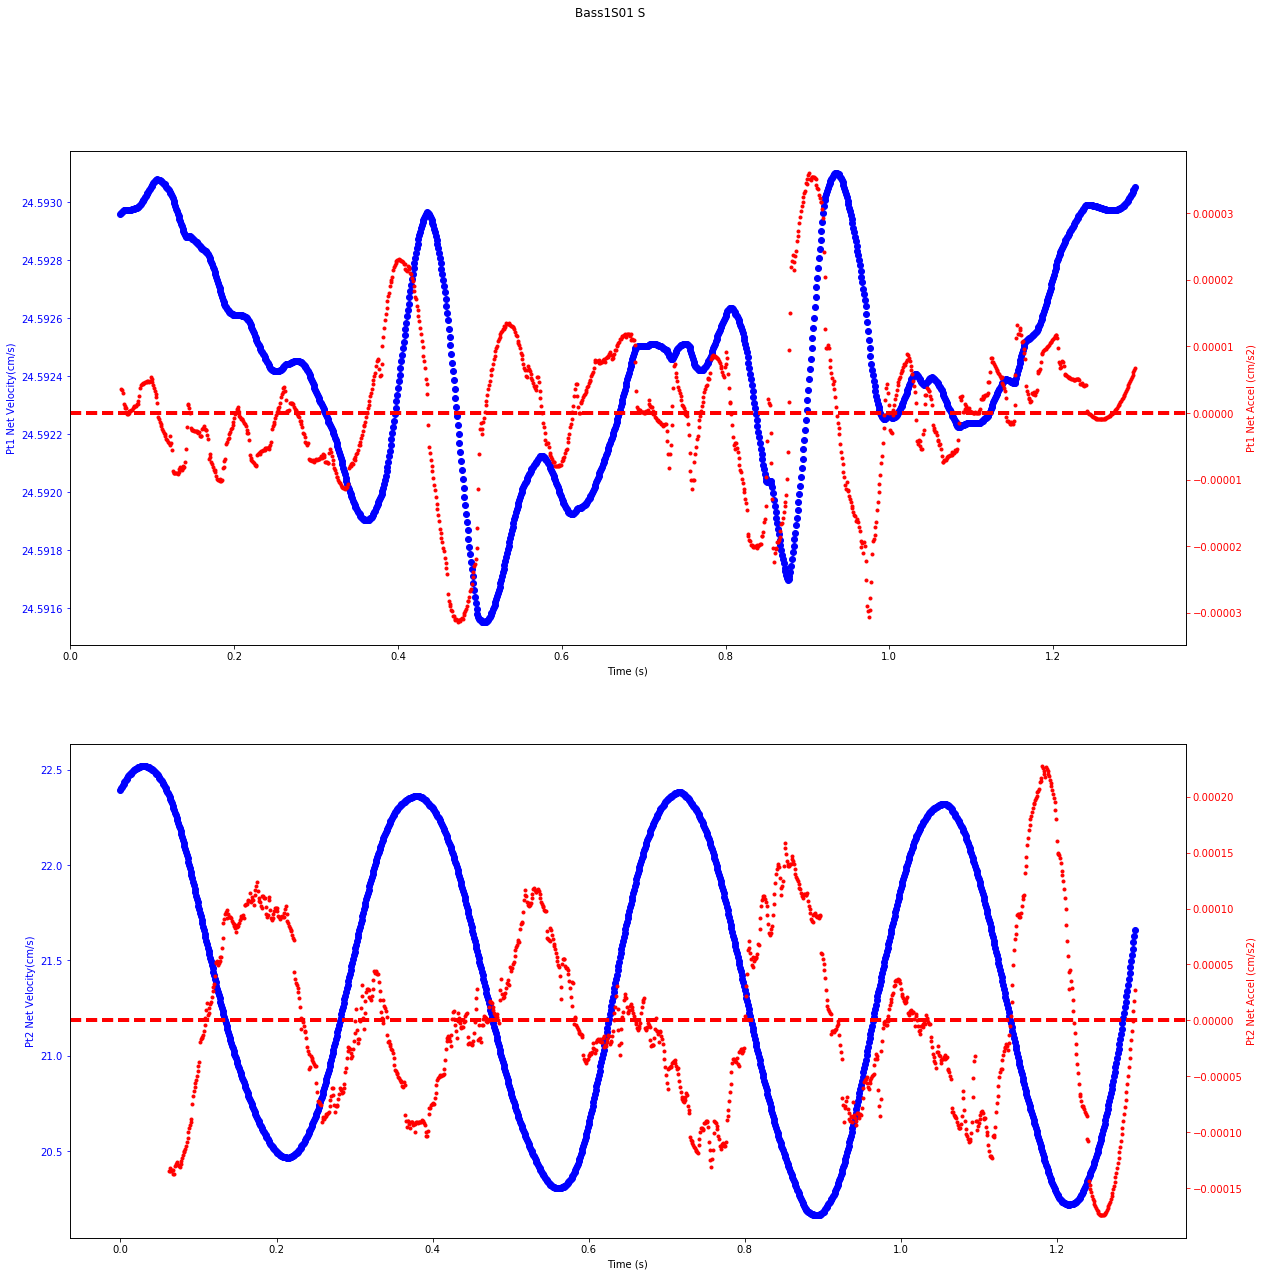

In [16]:
plot_track(['Bass1S01'], tracklist)
plot_accel(['Bass1S01'], tracklist)
plot_net_accel(['Bass1S01'], tracklist)

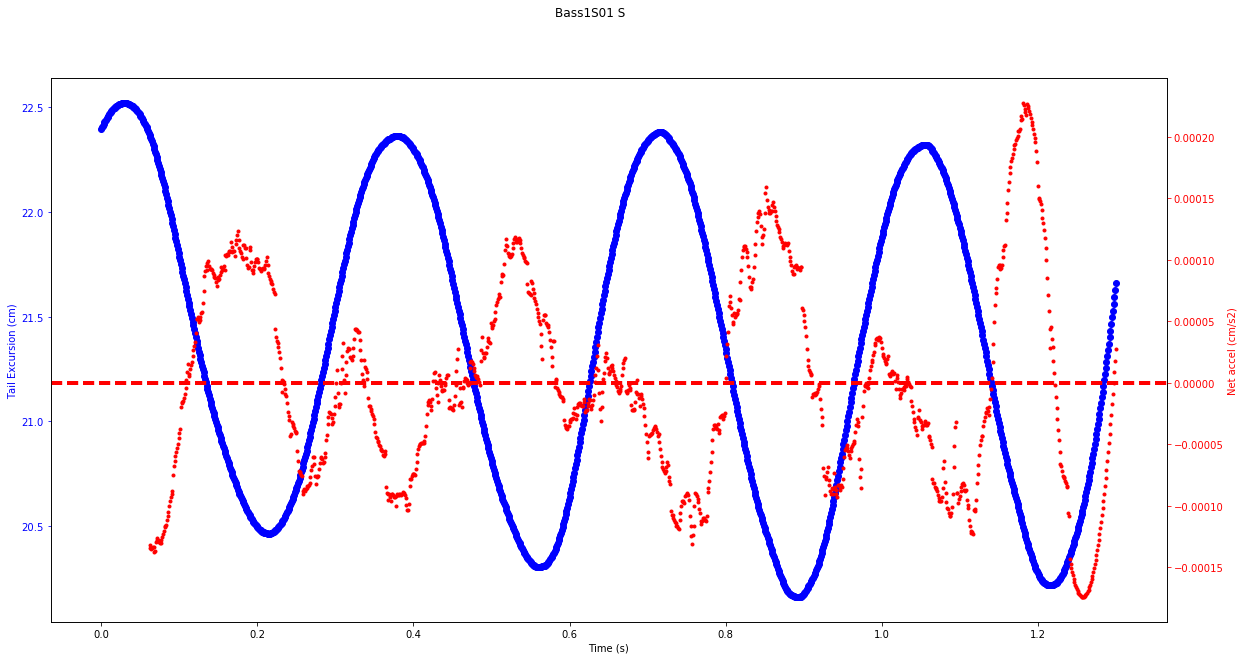

In [17]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(tracklist['Bass1S01']['sequence'] + ' ' +
             tracklist['Bass1S01']['behavior'])
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(tracklist['Bass1S01']['data'].index.values, tracklist['Bass1S01']['data']['pt2y_smth'], 'bo')
ax1.set_ylabel('Tail Excursion (cm)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(tracklist['Bass1S01']['data'].index.values, tracklist['Bass1S01']['data']['pt2_net_a'], 'r.')
ax2.set_ylabel('Net accel (cm/s2)', color='r')
ax1.set_xlabel('Time (s)')
ax2.tick_params('y', colors='r')
plt.axhline(0, color='r', linewidth=4, linestyle='dashed')
# plt.savefig(filename)
plt.show()

In [49]:
# Load all of the things
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D

matplotlib.rc('axes.formatter', useoffset=False)


def check_plots(tracklist_subset, tracklist):
    """Plot _____ from data as produced
            by process_points_pandas.py.

           Parameters
           ----------
           tracklist_subset : 1D array_like
               List of strings indicating sequence names of desired trials.
           tracklist : pandas dataframe
               tracklist dataframe produced by process_points_pandas.py

           Returns
           -------

           Notes
           -----


           References
           ----------

           Examples
           --------
           """
    # tracklist_subset = input("Input Desired Trial Subset as List")
    for trial in tracklist_subset:  # Iterates over all available trials

        # Scale time for colormap
        scaled_time = (tracklist[trial]['data'].index.values -
                       tracklist[trial]['data'].index.values.min()) / \
                      tracklist[trial]['data'].index.values.ptp()
        timemax = max(tracklist[trial]['data'].index.values)
        data = tracklist[trial]['data']
        colors = plt.cm.cubehelix(scaled_time)
        m = cm.ScalarMappable(cmap=cm.cubehelix)
        m.set_array(tracklist[trial]['data'].index.values)

        # filename = str(trial) + '.pdf'

        fig = plt.figure(figsize=(20, 20))
        fig.suptitle(tracklist[trial]['sequence'] + ' ' +
                     tracklist[trial]['behavior'])

        ax1 = fig.add_subplot(4, 2, 1, projection='3d')
        ax1.set_title('Pt 1 Position')
        ax1.scatter3D(xs=tracklist[trial]['data']['pt1x_smth'],
                      ys=tracklist[trial]['data']['pt1y_smth'],
                      zs=tracklist[trial]['data']['pt1z_smth'],
                      zdir='z', s=3, c=colors, marker='o',
                      edgecolor='none')  # 3D Scatter plot
        ax1.autoscale(enable=True, tight=True)
        ax1.set_xlabel('X position')
        ax1.set_ylabel('Y position')
        ax1.set_zlabel('Z position')
        plt.colorbar(m, shrink=0.5, aspect=10)

        ax2 = fig.add_subplot(4, 2, 3)
        ax2.plot(data.index.values, data['pt1y_v_smth'], 'bo')
        ax2.set_ylabel('Y velocity (cm/s)', color='b')
        ax2.tick_params('y', colors='b')

        ax3 = fig.add_subplot(4, 2, 5)
        ax3.plot(data.index.values, data['pt1_net_v'], 'bo')
        ax3.set_ylabel('Net Velocity (cm/s)', color='b')
        ax3.tick_params('y', colors='b')

        ax4 = fig.add_subplot(4, 2, 7)
        ax4.plot(data.index.values, data['pt1_net_a'], 'bo')
        ax4.set_ylabel('Net accel (cm/s2)', color='b')
        ax4.tick_params('y', colors='b')

        ax5 = fig.add_subplot(4, 2, 2, projection='3d')
        ax5.set_title('Pt 2 Position')
        ax5.scatter3D(xs=tracklist[trial]['data']['pt2x_smth'],
                      ys=tracklist[trial]['data']['pt2y_smth'],
                      zs=tracklist[trial]['data']['pt2z_smth'],
                      zdir='z', s=3, c=colors, marker='o',
                      edgecolor='none')  # 3D Scatter plot
        ax5.autoscale(enable=True, tight=True)
        ax5.set_xlabel('X position')
        ax5.set_ylabel('Y position')
        ax5.set_zlabel('Z position')
        plt.colorbar(m, shrink=0.5, aspect=10)

        ax6 = fig.add_subplot(4, 2, 4)
        ax6.plot(data.index.values, data['pt2y_v_smth'], 'bo')
        ax6.set_ylabel('Y velocity (cm/s)', color='b')
        ax6.tick_params('y', colors='b')

        ax7 = fig.add_subplot(4, 2, 6)
        ax7.plot(data.index.values, data['pt2_net_v'], 'bo')
        ax7.set_ylabel('Net Velocity (cm/s)', color='b')
        ax7.tick_params('y', colors='b')

        ax8 = fig.add_subplot(4, 2, 8)
        ax8.plot(data.index.values, data['pt2_net_a'], 'bo')
        ax8.set_ylabel('Net accel (cm/s2)', color='b')
        ax8.tick_params('y', colors='b')

        plt.show()

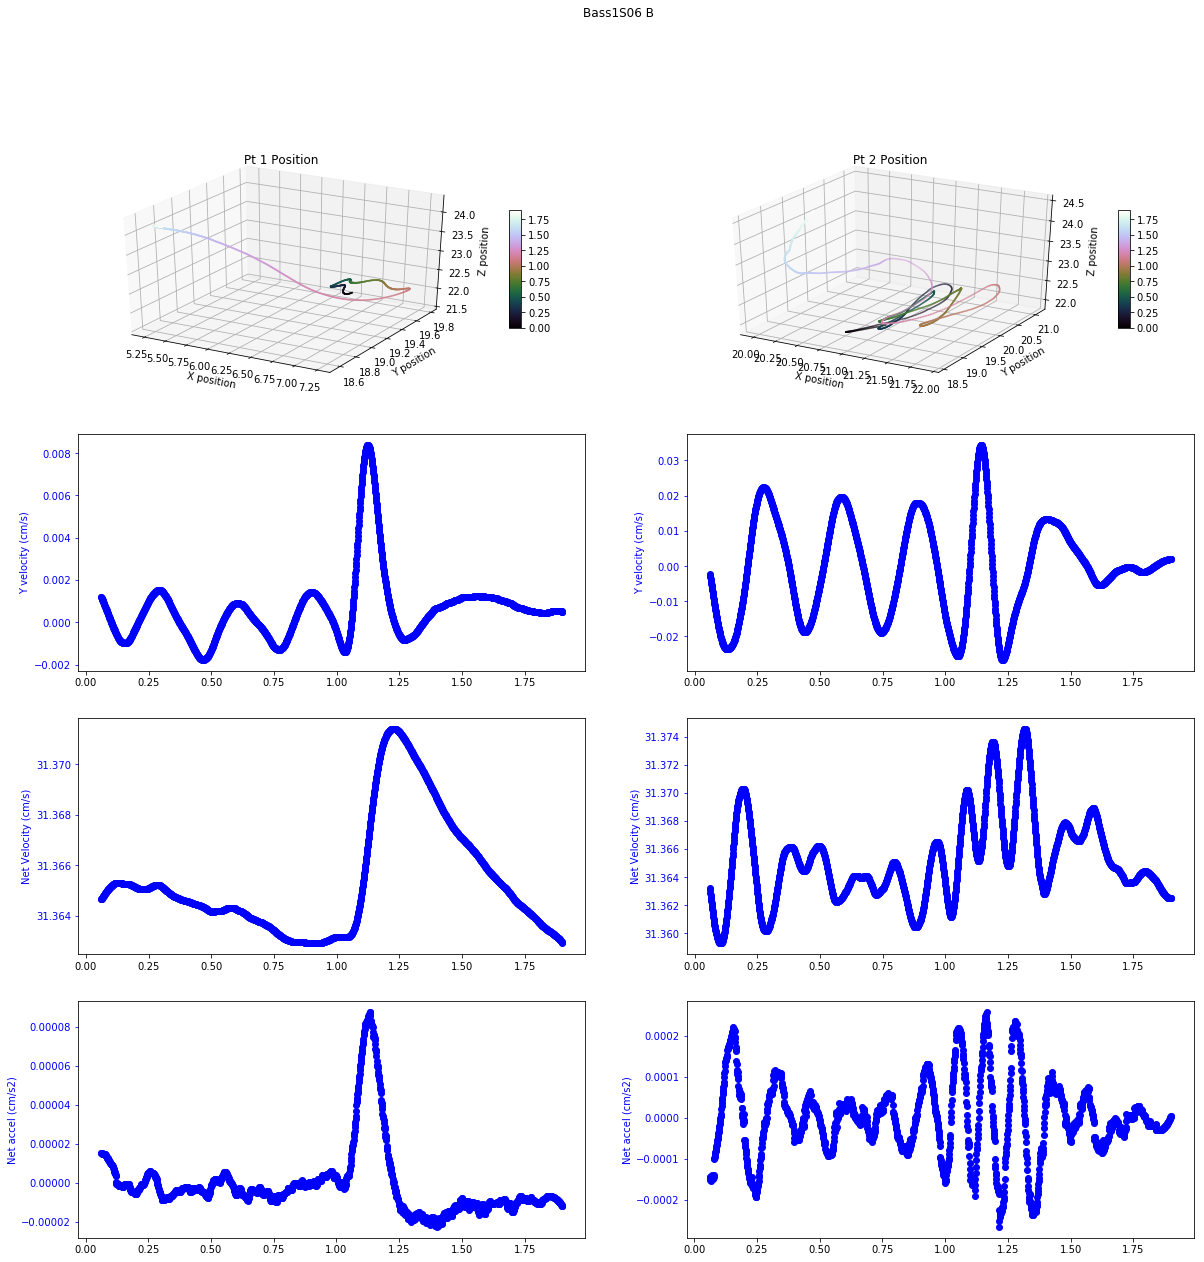

In [54]:
check_plots(['Bass1S06'], tracklist)